# Fermi-Hubbard model

# 1. Imports

In [1]:

# qiskit imports
import numpy as np
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.providers.aer.noise as noise
import sys
sys.path.append("..") # import one subdirectory up in files
#sys.path.append("..") # import one subdirectory up in files
#os.chdir("../holopy/")
import basic_circuits as circuits
from networks import IsoMPS
from isonetwork import QKParamCircuit, IsoTensor
import matplotlib.pyplot as plt
import scipy.linalg as la

# tenpy imports
from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS
from tenpy.networks.site import SpinHalfFermionSite, FermionSite
from tenpy.models.fermions_spinless import FermionModel
from tenpy.models.hubbard import FermiHubbardModel, FermiHubbardChain
from tenpy.models.spins import SpinModel

# classical circuit and thermal states imports
# import thermal state
#from thermal_state import thermal_state 
from circuit_qubit1 import Circuit
from hamiltonian import model_mpo

# 2. Circuit structure 

In [2]:

# model params
t = 1 # hopping
U = 1 # interaction strength
mu = 0 # chemical potential
layer = 4 # layer of FHM circuit structure 
L = 1 # length of repetitions of unit-cell
d = 2
chimax = 2
l_uc = 2 # length of unit-cell
N = L * l_uc # number of sites

In [3]:

# circuit structure (for spinhalf fermion)

def circuit(layer):
    """
    Layer = number of layers
    """
    def qub_x(params): return (np.pi/2, 0, params[0])
    def qub_y(params): return (np.pi/2, np.pi/2, params[0])
    def qub_z(params): return (0, 0, params[0])
    def qub_two(params): return (params[0])
    
    # circuit for first site
    c = Circuit([("qubit", "p", d), ("qubit", "p", d), ("qubit", "b", chimax),("qubit", "b", chimax)])
    # one qubit rotation
    c.add_gate("rotation", qids = [0], n_params = 1, fn = qub_z)
    i = 0
    while i < layer:
        c.add_gate("XX_YY", qids=[0, 2], n_params = 1, fn = qub_two)
        c.add_gate("ZZ", qids=[0, 2], n_params = 1, fn = qub_two)
        c.add_gate("XX_YY", qids=[1, 3], n_params = 1, fn = qub_two)
        c.add_gate("ZZ", qids=[1, 3], n_params = 1, fn = qub_two)
        
        i += 1
        if i < layer:
            c.add_gate("XX_YY", qids=[0, 1], n_params = 1, fn = qub_two)
            c.add_gate("ZZ", qids=[0, 1], n_params = 1, fn = qub_two)
            c.add_gate("XX_YY", qids=[2, 3], n_params = 1, fn = qub_two)
            c.add_gate("ZZ", qids=[2, 3], n_params = 1, fn = qub_two)
            i += 1
    # one qubit rotation
    c.add_gate("rotation", qids = [0], n_params = 1, fn = qub_z)
    c.assemble()

    # circuit for second site
    c1 = Circuit([("qubit", "p", d), ("qubit", "p", d), ("qubit", "b", chimax), ("qubit", "b", chimax)])
    # one qubit rotation
    c1.add_gate("rotation", qids = [0], n_params = 1, fn = qub_z)   
    i = 0
    while i < layer:
        c1.add_gate("XX_YY", qids=[0, 2], n_params = 1, fn = qub_two)
        c1.add_gate("ZZ", qids=[0, 2], n_params = 1, fn = qub_two)
        c1.add_gate("XX_YY", qids=[1, 3], n_params = 1, fn = qub_two)
        c1.add_gate("ZZ", qids=[1, 3], n_params = 1, fn = qub_two)
        
        i += 1
        if i < layer:
            c1.add_gate("XX_YY", qids=[0, 1], n_params = 1, fn = qub_two)
            c1.add_gate("ZZ", qids=[0, 1], n_params = 1, fn = qub_two)
            c1.add_gate("XX_YY", qids=[2, 3], n_params = 1, fn = qub_two)
            c1.add_gate("ZZ", qids=[2, 3], n_params = 1, fn = qub_two)
            i += 1
    # one qubit rotation
    c1.add_gate("rotation", qids = [0], n_params = 1, fn = qub_z)
    c1.assemble()
    return (c,c1)

# 3. Energy

In [4]:

# thermal-state-based Hamiltonian and boundary vects
Hamiltonian = model_mpo.fermi_hubbard(t,U,mu)
chi_H = Hamiltonian[0,:,0,0].size # size of Hamiltonian bond leg dimension
H_bvecr = None
H_bvecl = np.zeros(chi_H)
H_bvecl[-1] = 1
bdry_vecs2 = [H_bvecl,H_bvecr]

In [5]:

# DMRG calculations

def Hubbard_spinhalf_fermion_dmrg(t, U, mu, chi, bc, L):
    model_params = dict(L=L,t=t,U=U,mu=mu,bc_MPS = bc, 
                        cons_N = 'N',cons_Sz=None,verbose=True)
    M = FermiHubbardChain(model_params)
    site = SpinHalfFermionSite(cons_N = 'N', cons_Sz = None, filling = 1)
    product_state = ["up", "down"] * (M.lat.N_sites // 2)
    #psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc = M.lat.bc_MPS)
    psi = MPS.from_product_state([site]*M.lat.N_sites, product_state, bc = M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,
        'diag_method': 'ED_block',
        #'min_sweeps': 200,
        'trunc_params':{
            'chi_max':chi,
            'svd_min':1.e-12,
         },
        'lanczos_params':{
            'P_tol':1e-14,
            'E_tol_to_trunc':1e-12,
            'P_tol_to_truc':1e-14
        },
        'max_E_err':1e-12,
        'verbose':True,
    }
    #eng = dmrg.SingleSiteDMRGEngine(psi, M, dmrg_params)
    #eng = dmrg.DMRGEngine(psi, M, dmrg_params)
    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    E, psi = eng.run()  # equivalent to dmrg.run() up to the return parameters.
    filling_gs = psi.expectation_value("Ntot")
    print(filling_gs)
    #info = dmrg.run(psi, M, dmrg_params)
    #E = info['E']
    return (E, filling_gs)

def Hubbard_spinhalf_fermion_dmrg_run(t, U, mu, chi, bc, L):
    model_params = dict(L=L,t=t,U=U,mu=mu,bc_MPS = bc, 
                        cons_N = 'N',cons_Sz=None,verbose=True)
    M = FermiHubbardChain(model_params)
    site = SpinHalfFermionSite(cons_N = 'N', cons_Sz = None, filling = 1)
    product_state = ["up", "up"] * (M.lat.N_sites // 2)
    #psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc = M.lat.bc_MPS)
    psi = MPS.from_product_state([site]*M.lat.N_sites, product_state, bc = M.lat.bc_MPS)
    dmrg_params = {
        'mixer': True,
     'trunc_params':{
         'chi_max':chi,
     'svd_min':1.e-12,
            'P_tol_to_truc':1e-10
     },
    'max_E_err':1e-12,
     'verbose':True,
    }
    info = dmrg.run(psi, M, dmrg_params)
    E = info['E']
    filling_gs = psi.expectation_value("Ntot")
    print(filling_gs, E)
    if bc == 'infinite':
        E1 = E
    else:
        E1 = E/L
    return E1

E_infinite = Hubbard_spinhalf_fermion_dmrg_run(t,U,mu,chi=4,bc ='infinite',L=2)
E_finite = Hubbard_spinhalf_fermion_dmrg_run(t,U,mu,chi=4,bc ='finite',L=4)

Reading 'bc_MPS'='infinite' for config FermiHubbardChain
Reading 'cons_N'='N' for config FermiHubbardChain
Reading 'cons_Sz'=None for config FermiHubbardChain
Reading 'L'=2 for config FermiHubbardChain
Reading 't'=1 for config FermiHubbardChain
Reading 'U'=1 for config FermiHubbardChain
Reading 'mu'=0 for config FermiHubbardChain
Subconfig 'trunc_params'=Config(<4 options>, 'trunc_params') for config DMRG
Initial sweeps...
Updating environment
.
Reading 'max_E_err'=1e-12 for config DMRG
Reading 'mixer'=True for config DMRG
Updating environment
.....
sweep 10, age = 128
Energy = -0.9548368962038811, S = nan, norm_err = 1.4e-13
Current memory usage 241.7 MB, time elapsed: 1.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.9178e-02, max_E_trunc = 1.1519e-01
MPS bond dimensions: [4, 4]
disable mixer after 15 sweeps, final amplitude 3.05e-10
Updating environment
.....
sweep 20, age = 248
Energy = -0.9548369079655323, S = 0.9880514723287892, norm_err = 1.4e-13
Current me

/home/shahin75/anaconda3/lib/python3.8/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol_to_truc'] for config trunc_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/shahin75/anaconda3/lib/python3.8/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 4
Energy = -3.5753656204474726, S = nan, norm_err = 1.1e-01
Current memory usage 241.8 MB, time elapsed: 0.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2033e-01, max_E_trunc = 1.5591e-01
MPS bond dimensions: [4, 4, 4]
disable mixer after 15 sweeps, final amplitude 3.05e-10
sweep 20, age = 4
Energy = -3.5753656204474726, S = 1.0805521460010565, norm_err = 1.3e-01
Current memory usage 241.8 MB, time elapsed: 1.2 s
Delta E = 0.0000e+00, Delta S = nan (per sweep)
max_trunc_err = 6.0163e-02, max_E_trunc = 1.5161e-01
MPS bond dimensions: [4, 4, 4]
sweep 30, age = 4
Energy = -3.5753656204474749, S = 1.0805521460010565, norm_err = 9.8e-02
Current memory usage 241.8 MB, time elapsed: 1.6 s
Delta E = -2.2204e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0163e-02, max_E_trunc = 1.5161e-01
MPS bond dimensions: [4, 4, 4]
norm_tol=1.00e-05 not reached, norm_err=9.85e-02
DMRG finished after 30 sweeps.
total size = 4, maximum chi = 4
[1.01808101 1.026

/home/shahin75/anaconda3/lib/python3.8/site-packages/tenpy/algorithms/dmrg.py:420: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/shahin75/anaconda3/lib/python3.8/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol_to_truc'] for config trunc_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/shahin75/anaconda3/lib/python3.8/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [9]:

## free energy (test for MPDO):

T = 0
def circuit_qubit_free_energy(x,*args):
    circuit = args[0]
    circuit1 = args[1]
    L = args[2]
    T = args[3]
    Hamiltonian = args[4]
    chi_H = args[5]
    bdry_vecs1 = args[6]
    bdry_vecs2 = args[7]
    l_uc = args[8] 
    # unitary structures:
    u = circuit.get_tensor(x[0:circuit.n_params])
    u1 = circuit1.get_tensor(x[circuit.n_params:circuit.n_params +
                               circuit1.n_params])
    unitary_list = [u,u1]
    F = thermal_state.free_energy(unitary_list,
                                  x,'density_matrix',
                                  1,Hamiltonian,
                                  T, chi_H,
                                  bdry_vecs1,bdry_vecs2,
                                  'method_I',None) 
    return F
#### bdry_vecs1 = TBD for MPDO, bdry_vecs1 = [None,None] and for iMPDO, bdry_vecs1 = None
bdry_vecs1 = [None,None]
c = circuit(layer)[0]
c1 = circuit(layer)[1]
args = (c,c1,L,T,Hamiltonian,chi_H,bdry_vecs1,bdry_vecs2,l_uc)
rng = np.random.default_rng()
x0 = rng.uniform(high=2*np.pi,size=c.n_params + c1.n_params)
result = minimize(circuit_qubit_free_energy,x0=x0,args=args,method = 'nelder-mead')
sweet_spot = result.x
free_energy = result.fun
print(f'Free energy = {free_energy}, num of layer = {layer}, T = {T}')
print(f'DMRG estimate (finite length): {E_finite}')
print(f'DMRG estimate (infinite length): {E_infinite}')

Free energy = -0.8903660786678309, num of layer = 4, T = 0
DMRG estimate (finite length): -0.8938414051118687
DMRG estimate (infinite length): -0.954836907965678


In [ ]:

T = 0
# ansatz (for number of layers)
FL = [] 
layer_list = []
layer = 4
for j in range(1,layer):
    c = circuit(layer)[0]
    c1 = circuit(layer)[1]
    x0 = rng.uniform(high=2*np.pi,size=c.n_params + c1.n_params)
    args = (c,c1,1,T,Hamiltonian,chi_H,bdry_vecs1,bdry_vecs2,l_uc)
    result = minimize(circuit_qubit_free_energy,x0=x0,args=args,
                      method = 'nelder-mead')
    free_energy = result.fun
    FL.append(free_energy)
    layer_list.append(layer)

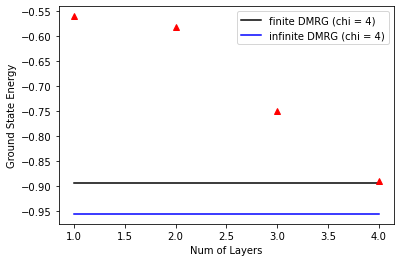

In [199]:
plt.plot(layer_list,len(layer_list)*[E_finite],'k')
plt.plot(layer_list,len(layer_list)*[E_infinite],'b')
plt.legend(['finite DMRG (chi = 4)','infinite DMRG (chi = 4)'])
plt.plot(layer_list,FL,'r^')
plt.ylabel('Ground State Energy')
plt.xlabel('Num of Layers')
plt.show()